In [ ]:
import pandas as pd
from pandas import read_csv, DataFrame
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score

import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX


##ARIMA

In [ ]:
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive"
!ls "/content/drive/My Drive/Colab Notebooks"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Classroom  'Colab Notebooks'   Videos	 Папка	 проекти
'Copy of featuretools.ipynb'
'Copy of Trees.ipynb'
'Copy of Untitled1 (1).ipynb'
'Copy of Untitled1.ipynb'
 crx.data
 data.csv
 Homework_1.ipynb
 Homework4.ipynb
 Homework5.ipynb
 HW11.ipynb
 HW9.ipynb
'hw_pandas (1).ipynb'
 hw_pandas.ipynb
'player_data (1).csv'
 player_data.csv
'Players (1).csv'
 Players.csv
'Seasons_Stats (1).csv'
 Seasons_Stats.csv
 T10Y2Y.csv
'topic2_practice_visual_titanic_solution (1).ipynb'
 topic2_practice_visual_titanic_solution.ipynb
 TreeHomework.ipynb
 Untitled0.ipynb
 Untitled2.ipynb
 winequality-red.csv
 winequality-white.csv


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/T10Y2Y.csv', sep=',', index_col=['DATE'], parse_dates=['DATE'], dayfirst=True)

df.head()

,T10Y2Y
DATE,
2018-07-23,0.32
2018-07-24,0.32
2018-07-25,0.28
2018-07-26,0.29
2018-07-27,0.29


In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2018-07-23 to 2023-07-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T10Y2Y  1305 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


(1305, 1)

TODO - обработать датасет так чтоб . была 0 и все данные были типа флоат

<Axes: xlabel='DATE'>

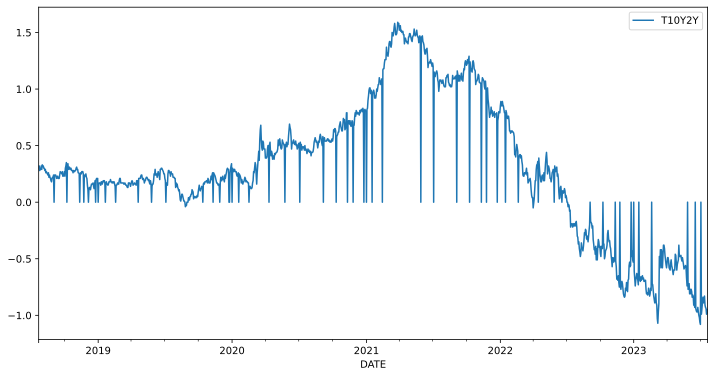

In [ ]:
from numpy.core.multiarray import may_share_memory
# df['T10Y2Y'].apply(lambda x:float(x.replace("'", '')))
df=df.astype(float)
df.plot(figsize=(12,6))

 есть смысл перейти к недельному интервалу и среднему значению


<Axes: xlabel='DATE'>

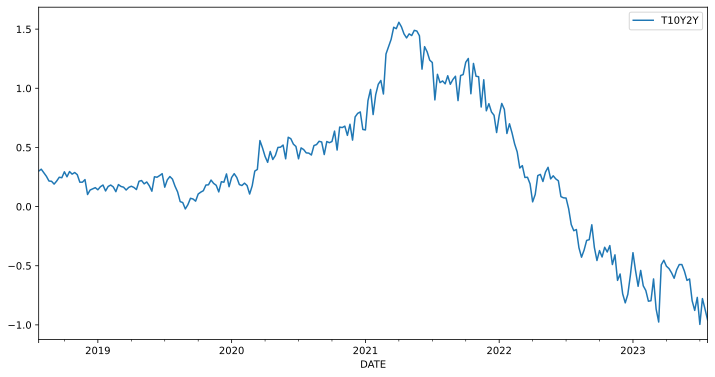

In [ ]:
df = df.resample('W').mean()
df.plot(figsize=(12,6))

ряд не является стационарным

,T10Y2Y
count,261.000000
mean,0.294889
std,0.580900
min,-0.996000
25%,0.084000
50%,0.246000
75%,0.622000
max,1.558000


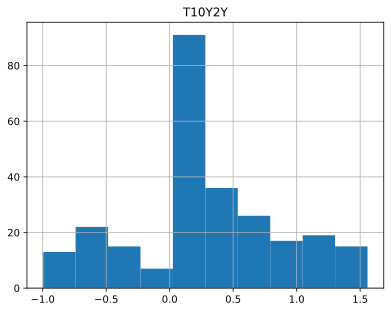

In [ ]:
itog = df.describe()
df.hist()
itog


ряд не однородный
Проведем тест Харки — Бера для определения номарльности распределения

In [ ]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(df)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print (itog)

         JB         
--------------------
  0.8707604179685454
  0.6470186180144055
0.010420997612266494
   2.717802312684138
--------------------


наш ряд имеет нормального распределения.
для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней

In [ ]:
test = sm.tsa.adfuller(df)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  0.16916672175376135
p-value:  0.9704782499118124
Critical values:  {'1%': -3.455952927706342, '5%': -2.8728086526320302, '10%': -2.572774990685656}
есть единичные корни, ряд не стационарен


In [ ]:
df1diff = df.diff(periods=1).dropna()

In [ ]:
test = sm.tsa.adfuller(df1diff)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -14.048638393225081
p-value:  3.206950266324102e-26
Critical values:  {'1%': -3.455952927706342, '5%': -2.8728086526320302, '10%': -2.572774990685656}
единичных корней нет, ряд стационарен


In [ ]:
m = df1diff.index[len(df1diff.index)/2+1]
r1 = sm.stats.DescrStatsW(df1diff[m:])
r2 = sm.stats.DescrStatsW(df1diff[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  [0.11479724]


<ipython-input-172-46ead6bc0745>:1: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  m = df1diff.index[len(df1diff.index)/2+1]


<Axes: xlabel='DATE'>

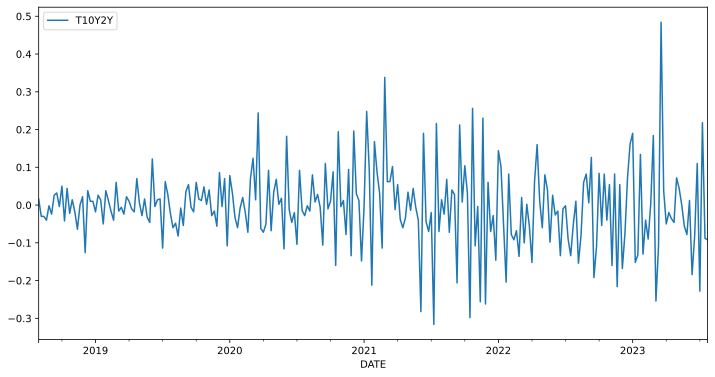

In [ ]:
df1diff.plot(figsize=(12,6))

Построение модели временного ряда

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


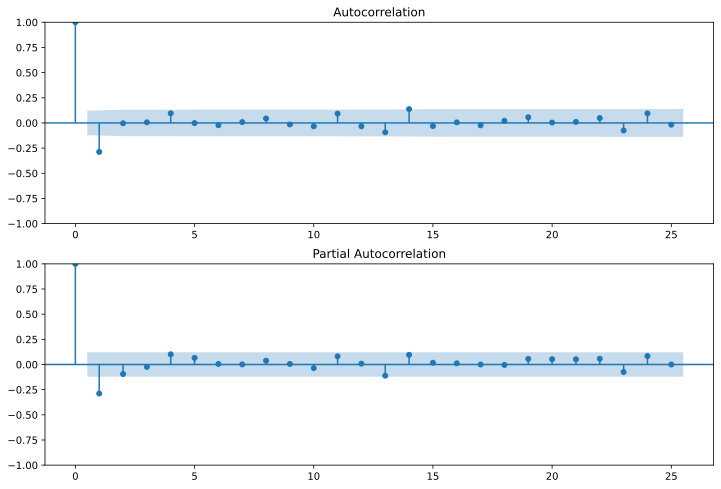

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1diff.values.squeeze(),  ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1diff, ax=ax2)

интегрированный ряд первого порядка
d=1 p=1 q=1

In [ ]:
src_data_model = df[:'2021-12-07']
model = sm.tsa.ARIMA(src_data_model, order=(1,1,1), seasonal_order=(1,1,0,12),  freq='W').fit()

посмотрим результаты

In [ ]:
print (model.summary())


                                     SARIMAX Results                                     
Dep. Variable:                            T10Y2Y   No. Observations:                  176
Model:             ARIMA(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 130.106
Date:                           Mon, 24 Jul 2023   AIC                           -252.211
Time:                                   12:43:46   BIC                           -239.836
Sample:                               07-29-2018   HQIC                          -247.187
                                    - 12-05-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1155      0.172     -0.672      0.501      -0.452       0.221
ma.L1         -0.2745      0.155     -1.773

In [ ]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print (DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.001313  0.971095
1    0.059701  0.970591
2    0.065868  0.995592
3    4.135662  0.387957
4    4.709322  0.452374
5    4.995460  0.544396
6    5.211272  0.634198
7    5.479386  0.705323
8    5.519961  0.786834
9    5.757327  0.835223
10   7.709805  0.739039
11  11.613984  0.477157
12  14.270843  0.355050
13  14.357706  0.423416
14  14.495795  0.488307
15  16.055957  0.449062
16  21.029692  0.224965
17  21.176959  0.270579
18  21.907363  0.288891
19  21.920918  0.344817
20  21.984576  0.400399
21  22.447307  0.433477


In [ ]:
pred = model.predict('2021-12-08','2023-07-21', typ='levels')
trn = df['2021-12-08':]
r2 = r2_score(trn, pred)
print (r2)

-0.20239275492621833


<Axes: xlabel='DATE'>

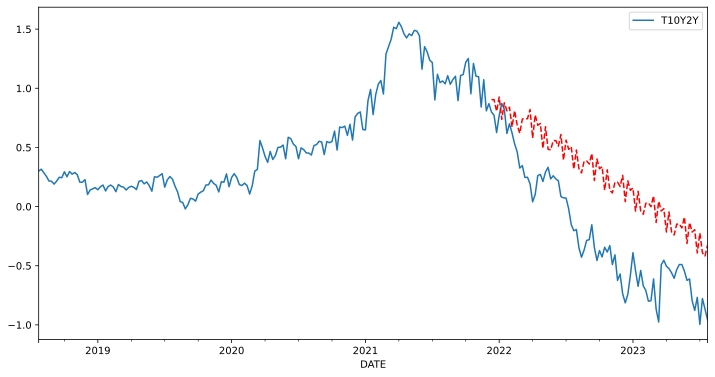

In [ ]:
df.plot(figsize=(12,6))
pred.plot(style='r--')

##SARIMA


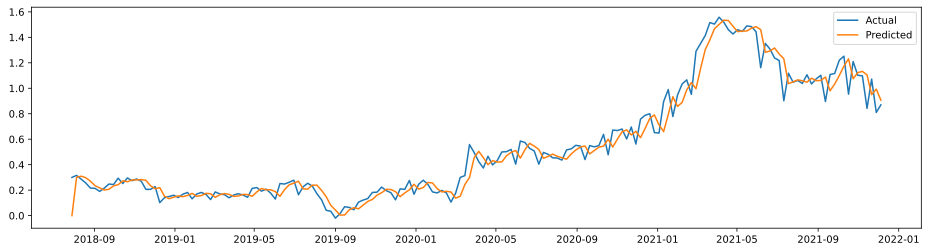

In [ ]:
sarima = SARIMAX(src_data_model,
                order=(1,1,1)
                )
predictions = sarima.fit().predict()
plt.figure(figsize=(16,4))
plt.plot(src_data_model, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
